In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb

In [ ]:
final_full_data = pd.read_csv("Full_data_features.csv")

In [ ]:
DLData = final_full_data
DLData['uid'] = DLData['ID']
DLData.drop(['ID','Unnamed: 0.1', 'Unnamed: 0', 'processed_path', 'path'], axis=1, inplace=True)
DLData['sex'] = DLData['sex'].fillna(DLData['gender'])
DLData = DLData.dropna(subset=['age', 'sex'])
DLData['sex'] = DLData['sex'].apply(lambda x: 1 if x.lower()[0] == 'm' else 0)
meta = pd.read_csv("additional_metadata.csv")
DLData

## MMSE

In [4]:
# Cell 1: Prepare Data for MMSE Regression (Updated: Split All Available MMSE Data)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Assume DLData is your dataframe

# Define non-feature columns to exclude (mmse is now target)
non_feature_cols = ['sex', 'mmse', 'label', 'MCL', 'dx', 'language', 'educ',
                    'gender', 'split', 'chunk_index', 'uid']

# Feature columns: all others (audio features; age and sex could be included if desired, but excluded as per previous)
feature_cols = [col for col in DLData.columns if col not in non_feature_cols]

# Filter all data where mmse is available (ignoring split since test has no mmse)
df_all = DLData[DLData['mmse'].notna()].copy()

# Grouped Split by UID into train_full (80%) and test (20%)
unique_uids = df_all['uid'].unique()
train_full_uids, test_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

df_train_full = df_all[df_all['uid'].isin(train_full_uids)]
df_test = df_all[df_all['uid'].isin(test_uids)]

# Extract X_test and y_test
X_test = df_test[feature_cols].values
y_test = df_test['mmse'].values

print(f"Test set shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Now split train_full into train (80%) and val (20%) by UID
train_full_unique_uids = df_train_full['uid'].unique()
train_uids, val_uids = train_test_split(train_full_unique_uids, test_size=0.2, random_state=42)

df_train = df_train_full[df_train_full['uid'].isin(train_uids)]
df_val = df_train_full[df_train_full['uid'].isin(val_uids)]

# Extract X_train, y_train, X_val, y_val
X_train = df_train[feature_cols].values
y_train = df_train['mmse'].values

X_val = df_val[feature_cols].values
y_val = df_val['mmse'].values

print(f"Train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Scale target (0-30 to [0,1])
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).squeeze()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).squeeze()

# Verify no UID overlap
train_uid_set = set(df_train['uid'].unique())
val_uid_set = set(df_val['uid'].unique())
test_uid_set = set(df_test['uid'].unique())
overlap_tv = train_uid_set & val_uid_set
overlap_tt = train_uid_set & test_uid_set
overlap_vt = val_uid_set & test_uid_set
print(f"UID overlap train-val: {len(overlap_tv)}, train-test: {len(overlap_tt)}, val-test: {len(overlap_vt)}")  # Should all be 0

Test set shape: (395, 2166), y_test shape: (395,)
Train shape: (1348, 2166), y_train shape: (1348,)
Val shape: (339, 2166), y_val shape: (339,)
UID overlap train-val: 0, train-test: 0, val-test: 0


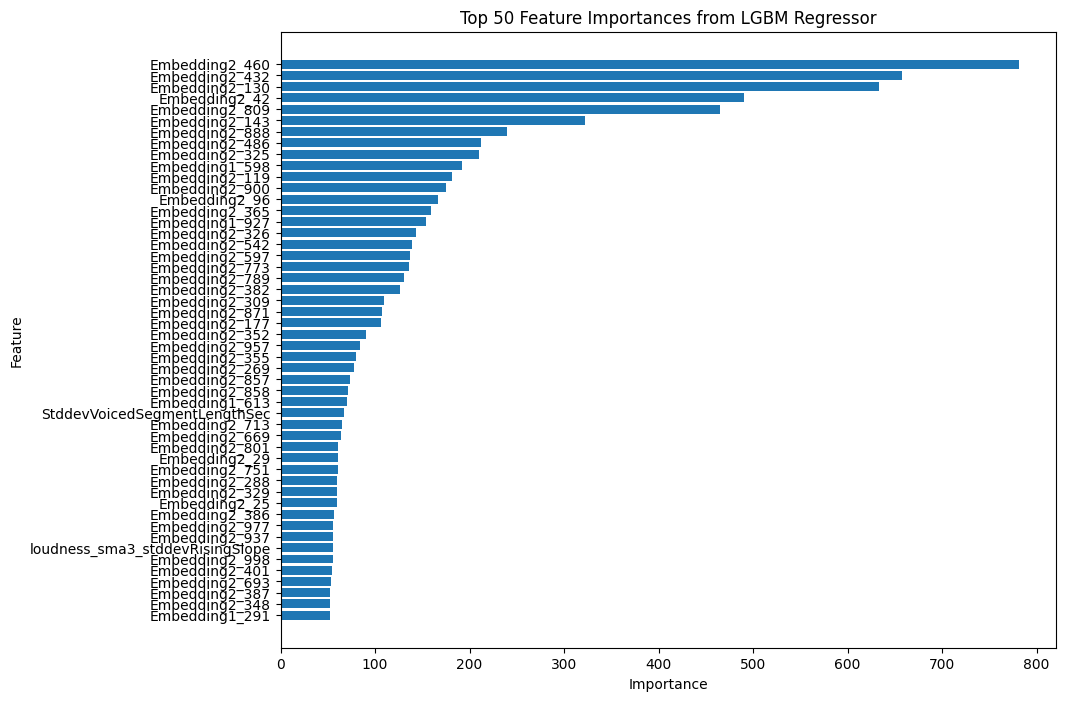

Top 10 Features by Importance:
             Feature  Importance
1601  Embedding2_460         781
1573  Embedding2_432         658
1271  Embedding2_130         633
1183   Embedding2_42         490
1950  Embedding2_809         465
1284  Embedding2_143         322
2029  Embedding2_888         240
1627  Embedding2_486         212
1466  Embedding2_325         210
715   Embedding1_598         192
Reduced shapes: Train (1348, 500), Val (339, 500), Test (395, 500)


In [5]:
# Cell 2: LightGBM for Feature Importance and Selection (Regression)
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train LGBM Regressor for importances
params = {
    'objective': 'regression',
    'metric': 'mae',
    'device': 'gpu',
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train_scaled)  # Use scaled for importance
model_lgb_imp = lgb.train(params, train_data, num_boost_round=1000)

# Get importances
importances = model_lgb_imp.feature_importance(importance_type='split')
feature_names = feature_cols

imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Visualize top 50
top_n = 50
plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'][:top_n], imp_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances from LGBM Regressor')
plt.gca().invert_yaxis()
plt.show()

print("Top 10 Features by Importance:")
print(imp_df.head(10))

# Select top 500 features
n_select = 500
selected_features = imp_df['Feature'][:n_select].tolist()
selected_indices = [feature_cols.index(f) for f in selected_features]

X_train_sel = X_train[:, selected_indices]
X_val_sel = X_val[:, selected_indices]
X_test_sel = X_test[:, selected_indices]

print(f"Reduced shapes: Train {X_train_sel.shape}, Val {X_val_sel.shape}, Test {X_test_sel.shape}")

LGBM Results Table:
          Set       MAE  Pearson Correlation
0  Validation  2.876772             0.773909
1        Test  3.078569             0.719188


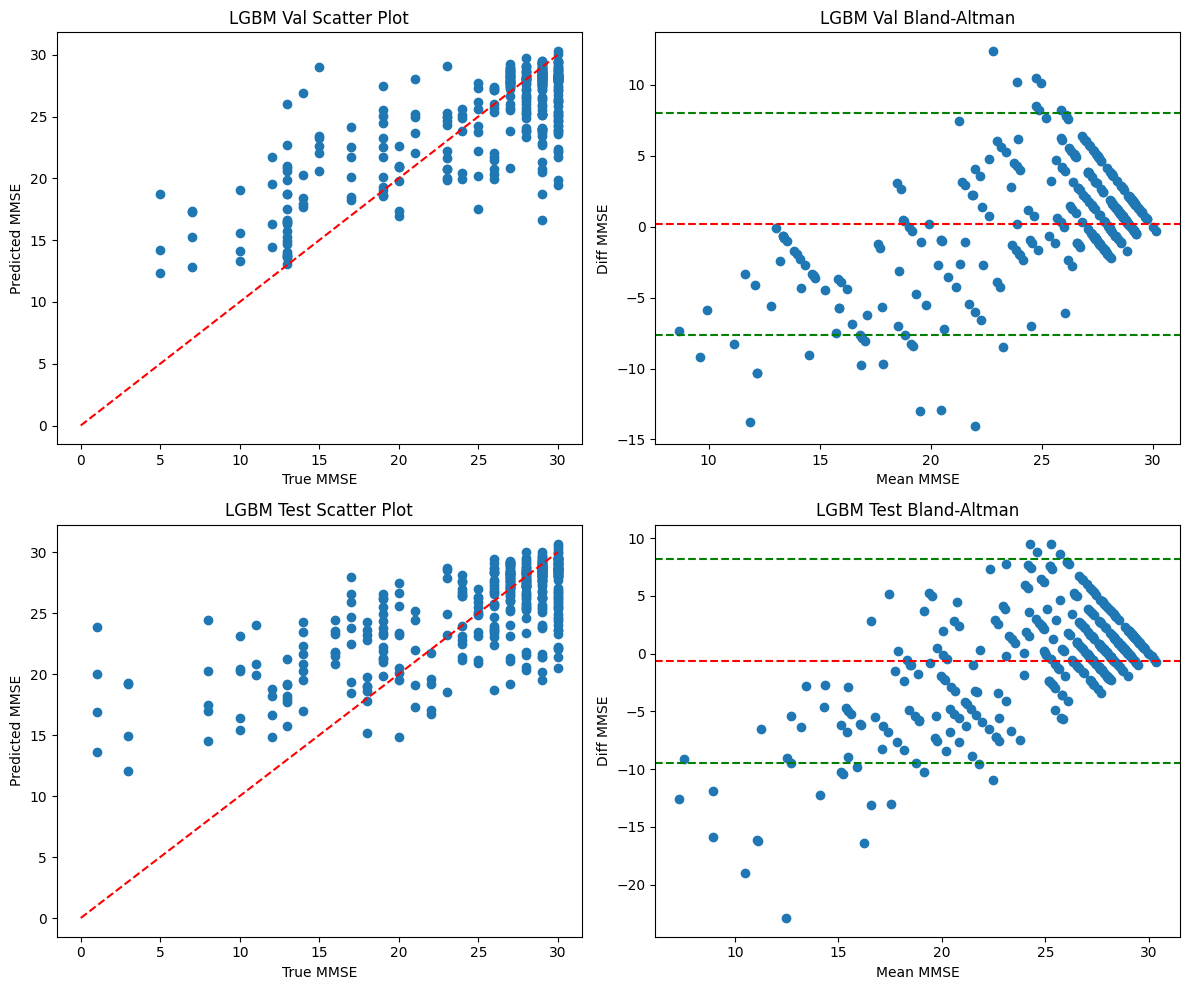

In [6]:
# Cell 3: LGBM Regression Training, Validation, and Test with Metrics and Plots
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train LGBM Regressor on scaled target
params = {
    'objective': 'regression',
    'metric': 'mae',
    'device': 'gpu',
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train_sel, label=y_train_scaled)
val_data = lgb.Dataset(X_val_sel, label=y_val_scaled, reference=train_data)

model_lgb = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

# Predict scaled, then inverse to original scale
y_pred_val_scaled = model_lgb.predict(X_val_sel)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).squeeze()

y_pred_test_scaled = model_lgb.predict(X_test_sel)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).squeeze()

# Metrics on original scale
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

pearson_val, _ = pearsonr(y_val, y_pred_val)
pearson_test, _ = pearsonr(y_test, y_pred_test)

# Bland-Altman: mean vs diff
mean_val = (y_val + y_pred_val) / 2
diff_val = y_val - y_pred_val
mean_test = (y_test + y_pred_test) / 2
diff_test = y_test - y_pred_test

mean_diff_val = np.mean(diff_val)
std_diff_val = np.std(diff_val)
mean_diff_test = np.mean(diff_test)
std_diff_test = np.std(diff_test)

# Results table
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'MAE': [mae_val, mae_test],
    'Pearson Correlation': [pearson_val, pearson_test]
})
print("LGBM Results Table:")
print(results_df)

# Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Scatter
axs[0, 0].scatter(y_val, y_pred_val)
axs[0, 0].plot([0, 30], [0, 30], 'r--')
axs[0, 0].set_xlabel('True MMSE')
axs[0, 0].set_ylabel('Predicted MMSE')
axs[0, 0].set_title('LGBM Val Scatter Plot')

# Val Bland-Altman
axs[0, 1].scatter(mean_val, diff_val)
axs[0, 1].axhline(mean_diff_val, color='r', linestyle='--')
axs[0, 1].axhline(mean_diff_val + 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].axhline(mean_diff_val - 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].set_xlabel('Mean MMSE')
axs[0, 1].set_ylabel('Diff MMSE')
axs[0, 1].set_title('LGBM Val Bland-Altman')

# Test Scatter
axs[1, 0].scatter(y_test, y_pred_test)
axs[1, 0].plot([0, 30], [0, 30], 'r--')
axs[1, 0].set_xlabel('True MMSE')
axs[1, 0].set_ylabel('Predicted MMSE')
axs[1, 0].set_title('LGBM Test Scatter Plot')

# Test Bland-Altman
axs[1, 1].scatter(mean_test, diff_test)
axs[1, 1].axhline(mean_diff_test, color='r', linestyle='--')
axs[1, 1].axhline(mean_diff_test + 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].axhline(mean_diff_test - 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].set_xlabel('Mean MMSE')
axs[1, 1].set_ylabel('Diff MMSE')
axs[1, 1].set_title('LGBM Test Bland-Altman')

plt.tight_layout()
plt.show()

GBM Results Table:
          Set       MAE  Pearson Correlation
0  Validation  3.213775             0.698056
1        Test  3.237841             0.651493


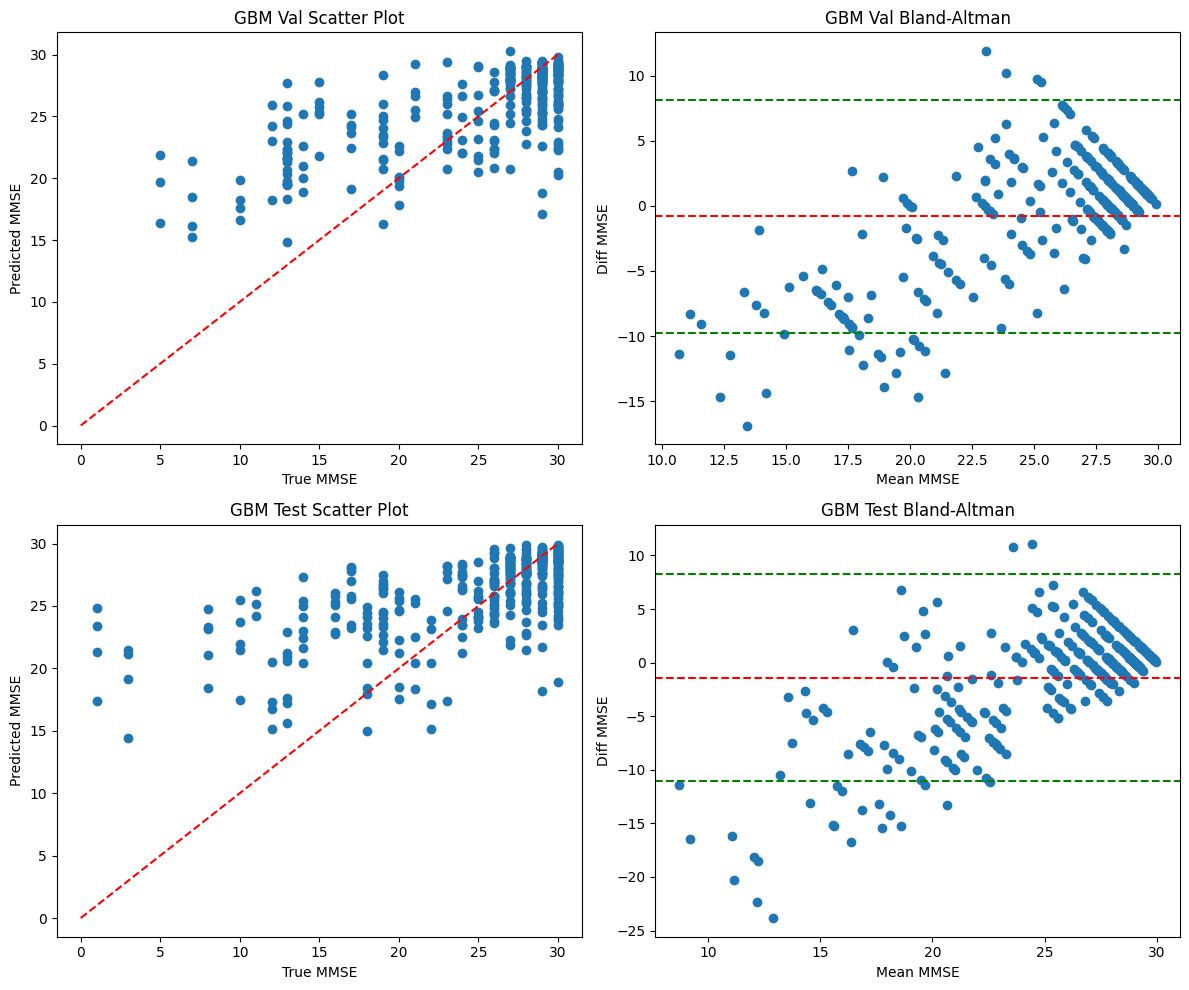

In [7]:
# Cell 4: GBM Regression Training, Validation, and Test with Metrics and Plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train GBM Regressor on scaled target
model_gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, loss='absolute_error')
model_gbm.fit(X_train_sel, y_train_scaled)

# Predict scaled, then inverse
y_pred_val_scaled = model_gbm.predict(X_val_sel)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).squeeze()

y_pred_test_scaled = model_gbm.predict(X_test_sel)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).squeeze()

# Metrics
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

pearson_val, _ = pearsonr(y_val, y_pred_val)
pearson_test, _ = pearsonr(y_test, y_pred_test)

# Bland-Altman
mean_val = (y_val + y_pred_val) / 2
diff_val = y_val - y_pred_val
mean_test = (y_test + y_pred_test) / 2
diff_test = y_test - y_pred_test

mean_diff_val = np.mean(diff_val)
std_diff_val = np.std(diff_val)
mean_diff_test = np.mean(diff_test)
std_diff_test = np.std(diff_test)

# Results table
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'MAE': [mae_val, mae_test],
    'Pearson Correlation': [pearson_val, pearson_test]
})
print("GBM Results Table:")
print(results_df)

# Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Scatter
axs[0, 0].scatter(y_val, y_pred_val)
axs[0, 0].plot([0, 30], [0, 30], 'r--')
axs[0, 0].set_xlabel('True MMSE')
axs[0, 0].set_ylabel('Predicted MMSE')
axs[0, 0].set_title('GBM Val Scatter Plot')

# Val Bland-Altman
axs[0, 1].scatter(mean_val, diff_val)
axs[0, 1].axhline(mean_diff_val, color='r', linestyle='--')
axs[0, 1].axhline(mean_diff_val + 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].axhline(mean_diff_val - 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].set_xlabel('Mean MMSE')
axs[0, 1].set_ylabel('Diff MMSE')
axs[0, 1].set_title('GBM Val Bland-Altman')

# Test Scatter
axs[1, 0].scatter(y_test, y_pred_test)
axs[1, 0].plot([0, 30], [0, 30], 'r--')
axs[1, 0].set_xlabel('True MMSE')
axs[1, 0].set_ylabel('Predicted MMSE')
axs[1, 0].set_title('GBM Test Scatter Plot')

# Test Bland-Altman
axs[1, 1].scatter(mean_test, diff_test)
axs[1, 1].axhline(mean_diff_test, color='r', linestyle='--')
axs[1, 1].axhline(mean_diff_test + 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].axhline(mean_diff_test - 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].set_xlabel('Mean MMSE')
axs[1, 1].set_ylabel('Diff MMSE')
axs[1, 1].set_title('GBM Test Bland-Altman')

plt.tight_layout()
plt.show()

TabPFN Results Table:
          Set       MAE  Pearson Correlation
0  Validation  2.388947             0.776894
1        Test  2.707715             0.728762


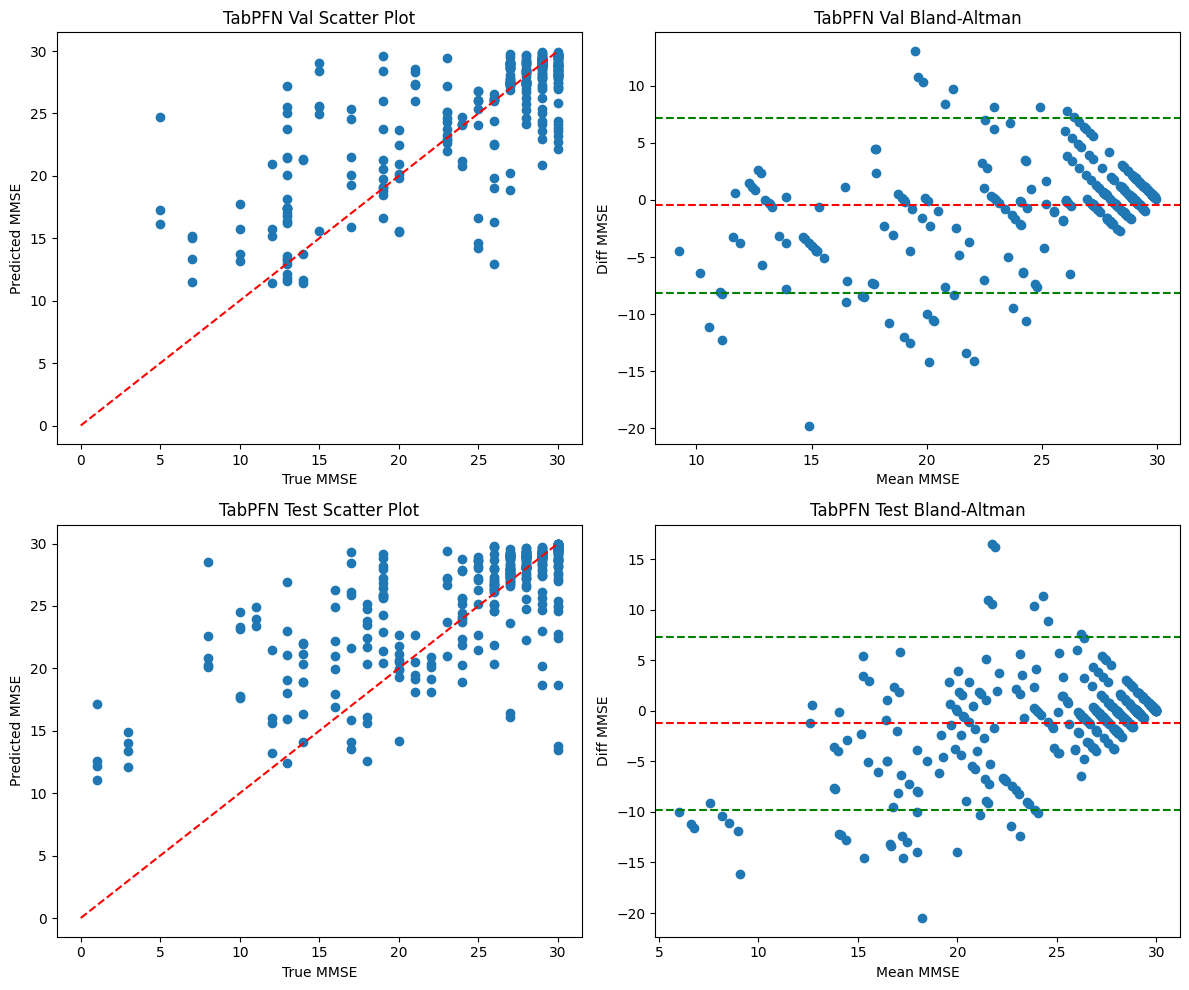

In [8]:
# Cell 5: TabPFN Regression Training, Validation, and Test with Metrics and Plots
# Install if needed: !pip install tabpfn
from tabpfn import TabPFNRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize TabPFNRegressor (assuming it's available; use device='cuda:0' for GPU)
model_tabpfn = TabPFNRegressor(device='cuda:1')

# Fit on scaled target
model_tabpfn.fit(X_train_sel, y_train_scaled)

# Predict scaled, then inverse
y_pred_val_scaled = model_tabpfn.predict(X_val_sel)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).squeeze()

y_pred_test_scaled = model_tabpfn.predict(X_test_sel)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).squeeze()

# Metrics
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)

pearson_val, _ = pearsonr(y_val, y_pred_val)
pearson_test, _ = pearsonr(y_test, y_pred_test)

# Bland-Altman
mean_val = (y_val + y_pred_val) / 2
diff_val = y_val - y_pred_val
mean_test = (y_test + y_pred_test) / 2
diff_test = y_test - y_pred_test

mean_diff_val = np.mean(diff_val)
std_diff_val = np.std(diff_val)
mean_diff_test = np.mean(diff_test)
std_diff_test = np.std(diff_test)

# Results table
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'MAE': [mae_val, mae_test],
    'Pearson Correlation': [pearson_val, pearson_test]
})
print("TabPFN Results Table:")
print(results_df)

# Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Scatter
axs[0, 0].scatter(y_val, y_pred_val)
axs[0, 0].plot([0, 30], [0, 30], 'r--')
axs[0, 0].set_xlabel('True MMSE')
axs[0, 0].set_ylabel('Predicted MMSE')
axs[0, 0].set_title('TabPFN Val Scatter Plot')

# Val Bland-Altman
axs[0, 1].scatter(mean_val, diff_val)
axs[0, 1].axhline(mean_diff_val, color='r', linestyle='--')
axs[0, 1].axhline(mean_diff_val + 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].axhline(mean_diff_val - 1.96 * std_diff_val, color='g', linestyle='--')
axs[0, 1].set_xlabel('Mean MMSE')
axs[0, 1].set_ylabel('Diff MMSE')
axs[0, 1].set_title('TabPFN Val Bland-Altman')

# Test Scatter
axs[1, 0].scatter(y_test, y_pred_test)
axs[1, 0].plot([0, 30], [0, 30], 'r--')
axs[1, 0].set_xlabel('True MMSE')
axs[1, 0].set_ylabel('Predicted MMSE')
axs[1, 0].set_title('TabPFN Test Scatter Plot')

# Test Bland-Altman
axs[1, 1].scatter(mean_test, diff_test)
axs[1, 1].axhline(mean_diff_test, color='r', linestyle='--')
axs[1, 1].axhline(mean_diff_test + 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].axhline(mean_diff_test - 1.96 * std_diff_test, color='g', linestyle='--')
axs[1, 1].set_xlabel('Mean MMSE')
axs[1, 1].set_ylabel('Diff MMSE')
axs[1, 1].set_title('TabPFN Test Bland-Altman')

plt.tight_layout()
plt.show()